Following from my previous post on fetching my Last.fm scrobbles (check it out here
if you want to see how I did it), I am now in the situation where I have more than
ten years worth of data and no idea what to do with it. 

My first thought was to visualize my top artists, and I decided to experiment a
bit with how I could do that. I have recently found a very nice website (aptly) 
named [The Python Graph Gallery](https://python-graph-gallery.com), which has 
a lot of interesting examples of how to visualize data using Python. 

Out of all the examples, there were a couple I found particularly interesting, 
so I decided to apply them to my own data. However, before getting to that 
point, I had to do a lot of data wrangling to get my data into the proper format. 

This was all done using Python and the Polars library, so if you're not interested
in the plots, but you're curious to see some funky polars code do keep reading.

## Preparing the data
First, I imported the various libraries I need:
- `datetime` was needed for some datetime manipulation
- `matplotlib` because I wanted to push it further than I usually do
- `polars` for all data manipulation
- `skrub` for some cleaning and for the `TableReport` (also it's the library I work on)
- `scipy.ndimage` for data smoothing and make the first plot prettier

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from skrub import Cleaner, TableReport
from scipy.ndimage import gaussian_filter1d

First, I read the data from the CSV file I generated in the previous post, then
I pass it to the `Cleaner` class from `skrub` to clean it up a bit.

Then, I use the `TableReport` to look at the data and see what it looks like.

In [2]:
df = pl.read_csv("data/recent-tracks.csv")
cleaner = Cleaner()
df = cleaner.fit_transform(df)
TableReport(df, verbose=0)

,,,,,,,


The `TableReport` is a pretty neat tool with a lot of features. In this case, I 
was particularly interested in the `Stats` tab, which shows various high-level
statistics about each column in the table. Here, it immediately shows me that 
some columns include a lot of missing values: the `artist_mbid` column has 
about 24% missing values, while both the `album_mbid` and `track_mbid` columns
have more than 40% missing values. 

What is the mbid? It is the [MusicBrainz Identifier](https://musicbrainz.org/doc/MusicBrainz_Identifier), 
a unique identifier for each artist, album, and track in the MusicBrainz database.

Why does it matter? Because it allows me to link artists and tracks with the 
MusicBrainz database, which contains additional information about them, such 
as the genre, the release date, the country of origin, and so on. 
In other words, missing the mbid means I am missing out on a lot of additional
inforamtion that I could use for new plots. This is a shame, and I already have
plans on how to fix this (maybe a future post?). 

For this post, I will focus on the artists, the tracks, and the timestamps of the
scrobbles, to showcase the evolution of my favorite artists over the years. 
Originally, I wanted to include the genres as well, as they have a larger 
granularity and would therefore be easier to visualize, but the data dump I 
have does not include them, and even querying the Last.fm API did not help with 
filling in the gaps for most of the less popular artists in my library.

In any case, lets move on to the actual data wrangling. 

First off, I want to parse the timestamps into a proper datetime format,
so I can use them to group the data by year and month:

In [3]:
df = df.with_columns(pl.col("utc_time").str.to_datetime(format="%d %b %Y, %H:%M")).sort(
    "utc_time"
)

Then, I extract the top 15 artists from the data based on the number of scrobbles. 
I need this list because I want to treat them separately from all the other artists:
this comes into play later for the stackplot. 

In [4]:
top_k = 15
top_artists = (
    df.group_by("artist") # group by artist
    .agg(pl.len().alias("count")) # count the number of scrobbles per artist
    .top_k(k=top_k, by="count") # get the top k artists
)
top_artists

artist,count
str,u32
"""Muse""",11017
"""Coldplay""",5470
"""Jovanotti""",5444
"""Negrita""",4767
"""Zucchero""",3879
…,…
"""Daft Punk""",1479
"""Avicii""",1470
"""U2""",1276


Now for the nasty wrangling part. Since my objective is to visualize the evolution
of my favorite artists over time, I can do this by counting the number of scrobbles
per artist each month. 

However, what I want from my stackplot is to show how many
of the scrobbles in each month come from one of the top 15 artists, and how many
come from the rest. For this, I need to find the _fraction_ of scrobbles per month
per artist. To avoid skewing the results in months where I listened to very few
of the top artists, I will also include the total number of scrobbles for 
"everyone else" in the fraction.

In [5]:
df_prep = (
    df.with_columns(
        pl.when(pl.col("artist").is_in(top_artists["artist"])) # check if artist is in top artists
        .then(pl.col("artist")) # keep the artist name
        .otherwise(pl.lit("Everyone else")) # otherwise label as "Everyone else"
        .alias("artist") # replace the artist column with this new one
    )
)

Now that I have the top artists and "everyone else", I can count the number of 
scrobbles per artist each month. For this, I first select only the artist and the
timestamp columns, then I truncate the timestamp to the month, and finally I 
group the data by artist and month, counting the number of scrobbles for each
group, i.e., for each artist in each month.

In [6]:
df_prep = (df_prep
    .select( 
        [
            pl.col("artist"),
            pl.col("utc_time").dt.truncate("1mo"), # truncate the time to the month
        ]
    )
    .group_by(["artist", "utc_time"])
    .agg(count=pl.len())
    .sort(["utc_time", "count"])
)
df_prep

artist,utc_time,count
str,datetime[μs],u32
"""Mika""",2012-12-01 00:00:00,1
"""U2""",2012-12-01 00:00:00,1
"""Caparezza""",2012-12-01 00:00:00,2
"""Zucchero""",2012-12-01 00:00:00,13
"""Negrita""",2012-12-01 00:00:00,15
…,…,…
"""Hoshimachi Suisei""",2025-04-01 00:00:00,53
"""Coldplay""",2025-04-01 00:00:00,73
"""Negrita""",2025-04-01 00:00:00,81


Each row in `df_prep` now contains the artist name, the month of the scrobble, 
and the number of scrobbles for that artist in that month. 

Now, I want to calculate the fraction of scrobbles per artist each month,
so I can use it in the stackplot. For this, I need to group the data
by month to find the total number of scrobbles for each month, then add a new 
column where I store the fraction, that is the number of scrobbles for the artist
divided by the total number of scrobbles for that month.

In [7]:
df_prep = df_prep.join( 
        df_prep # self-join to add the total number of scrobbles per month
        .group_by("utc_time") # group by month
        .agg(pl.sum("count")), # total number of scrobbles per month
        on="utc_time" 
    ).with_columns(
        frac=pl.col("count") / pl.col("count_right") * 100 # calculate the fraction 
)

In [8]:

ranking = df_prep.group_by("artist").agg(pl.sum("count")).sort("count", descending=True)
order = ranking["artist"].to_list()

In [9]:
order

['Everyone else',
 'Muse',
 'Coldplay',
 'Jovanotti',
 'Negrita',
 'Zucchero',
 'Francesco Guccini',
 'TheFatRat',
 'Hoshimachi Suisei',
 'Caparezza',
 'Ado',
 'Daft Punk',
 'Avicii',
 'U2',
 'YOASOBI',
 'Mika']

In [10]:
all_time = pl.DataFrame(
    {
        "time": pl.datetime_range(
            start=datetime(2012, 12, 1),
            end=datetime(2025, 4, 20),
            interval="1mo",
            eager=True,
        )
    }
)

dict_frac = {}
dict_abs = {}
dict_cumulative = {}
labels = []

for gidx, g in df_prep.group_by("artist"):
    group = g.with_columns(pl.col("utc_time").dt.truncate("1mo")).join(
        all_time, left_on="utc_time", right_on="time", how="right"
    ).with_columns(pl.col("frac").fill_null(0))

    dict_frac[gidx[0]] = group["frac"].to_numpy()
    dict_abs[gidx[0]] = group["count"].to_numpy()
    dict_cumulative[gidx[0]] = group["count"].fill_null(0).cum_sum().to_numpy()
    labels.append(gidx[0])

dict_frac = {k: dict_frac[k] for k in order}
dict_abs = {k: dict_abs[k] for k in order}
dict_cumulative = {k: dict_cumulative[k] for k in order}
dict_total = dict(ranking.rows())

In [11]:
x = all_time["time"].to_numpy()
y = np.array(list(dict_frac.values()))
sigma = 2
mask = ~(y.sum(axis=0) == 0)
y = y[:, mask]
x = x[mask]
y = gaussian_filter1d(y, sigma=sigma)

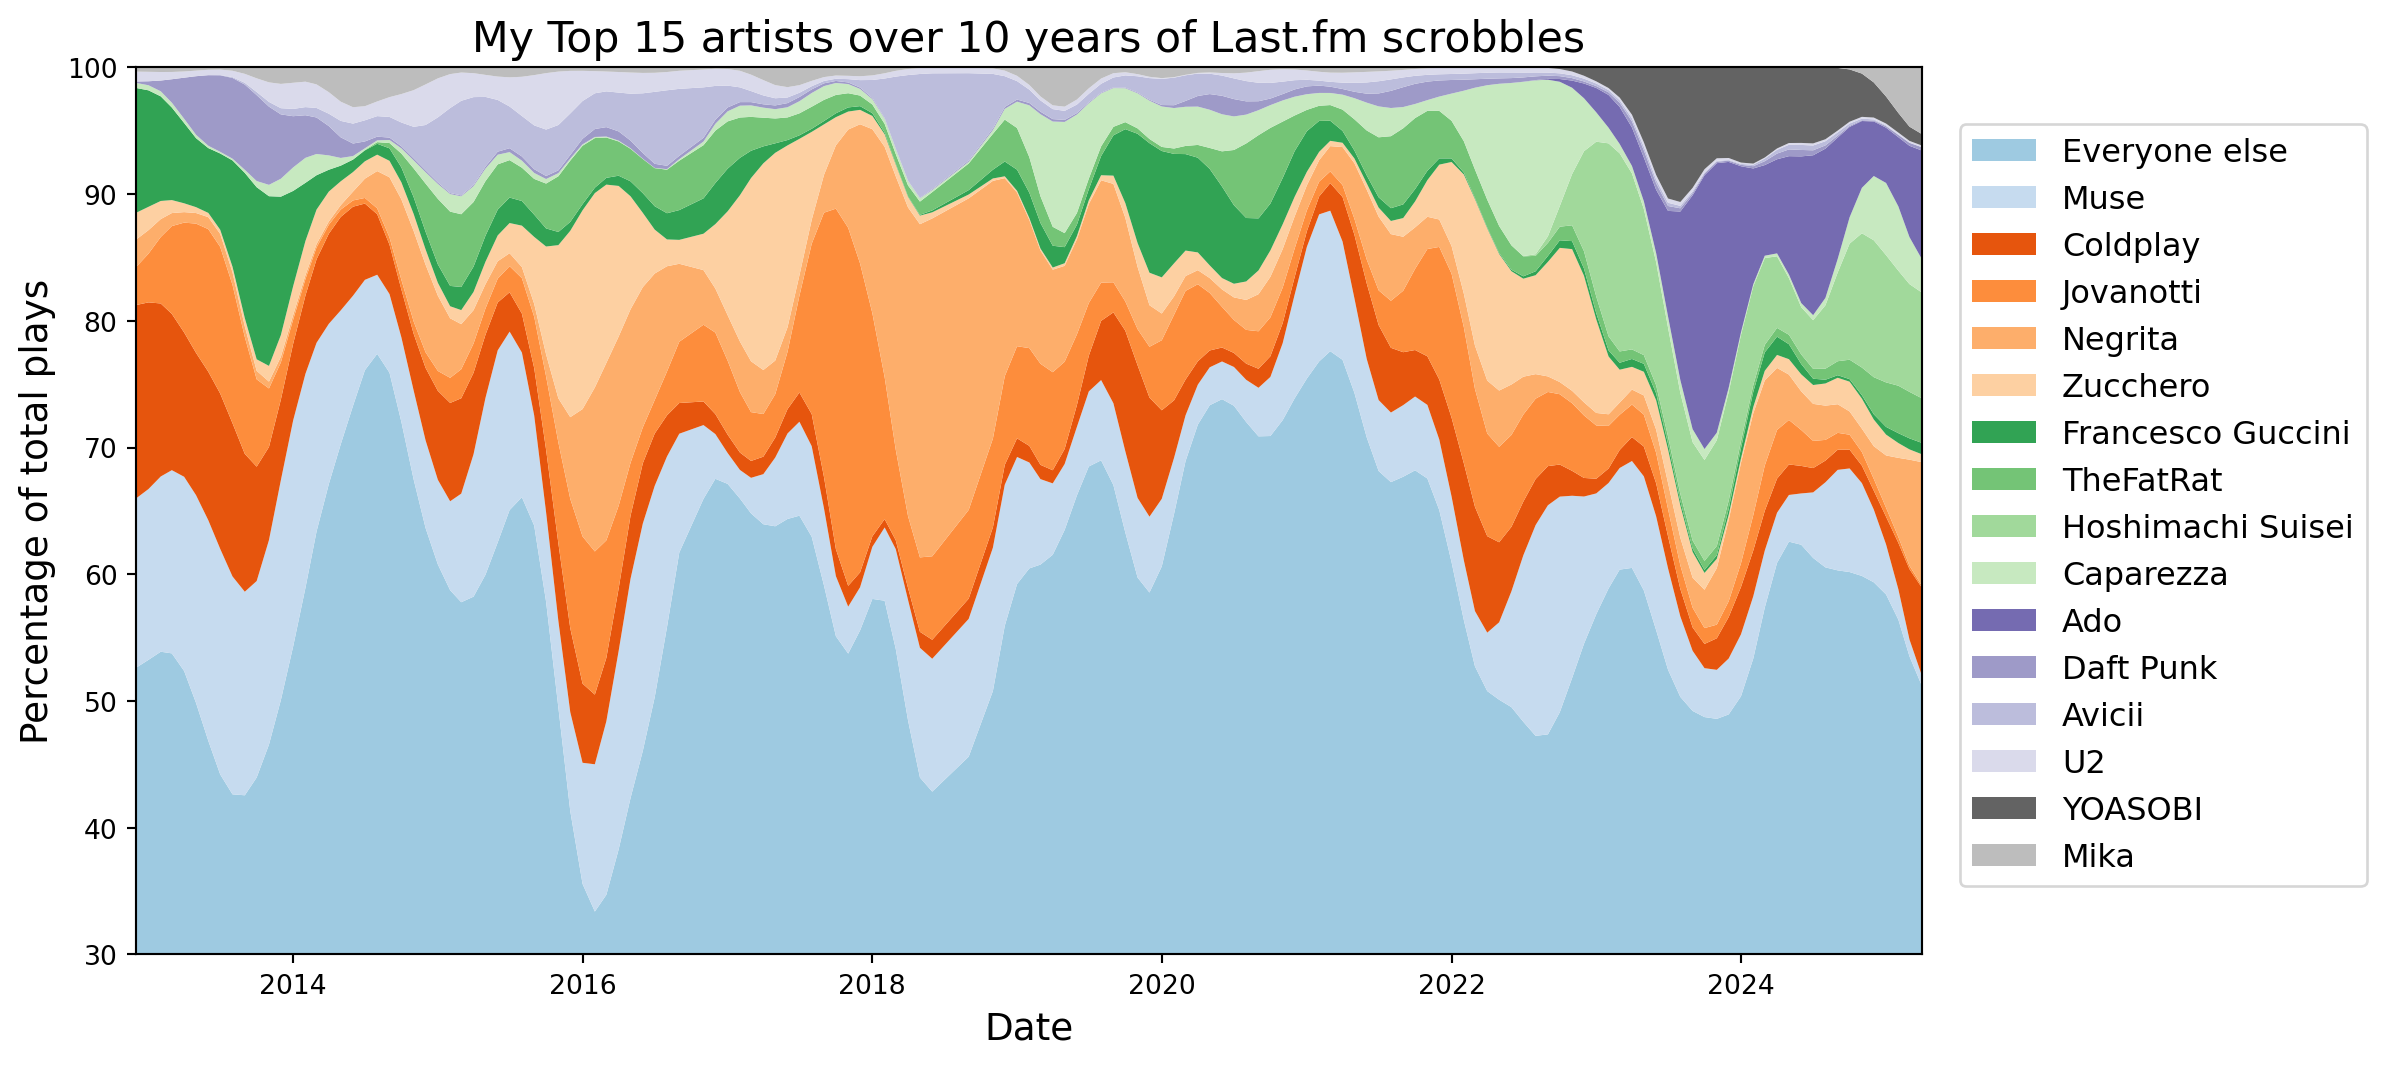

In [12]:
cmap = plt.cm.tab20c
# colors=  cmap
colors = cmap(np.linspace(0.1, 0.9, len(order)))
fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(
    x,
    y,
    labels=order,
    # alpha=0.5,
    colors=colors,
    # baseline="wiggle"
)
fig.legend(loc="center right", ncol=1, fontsize=12, bbox_to_anchor=(1.1, 0.5))


ax.set_xlim(x[0], x[-1])
ax.set_ylim(30, 100)

ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Percentage of total plays", fontsize=14)
ax.set_title(f"My Top {top_k} artists over 10 years of Last.fm scrobbles", fontsize=16)

fig.savefig("top_artists_stackplot.png", dpi=300, bbox_inches="tight")

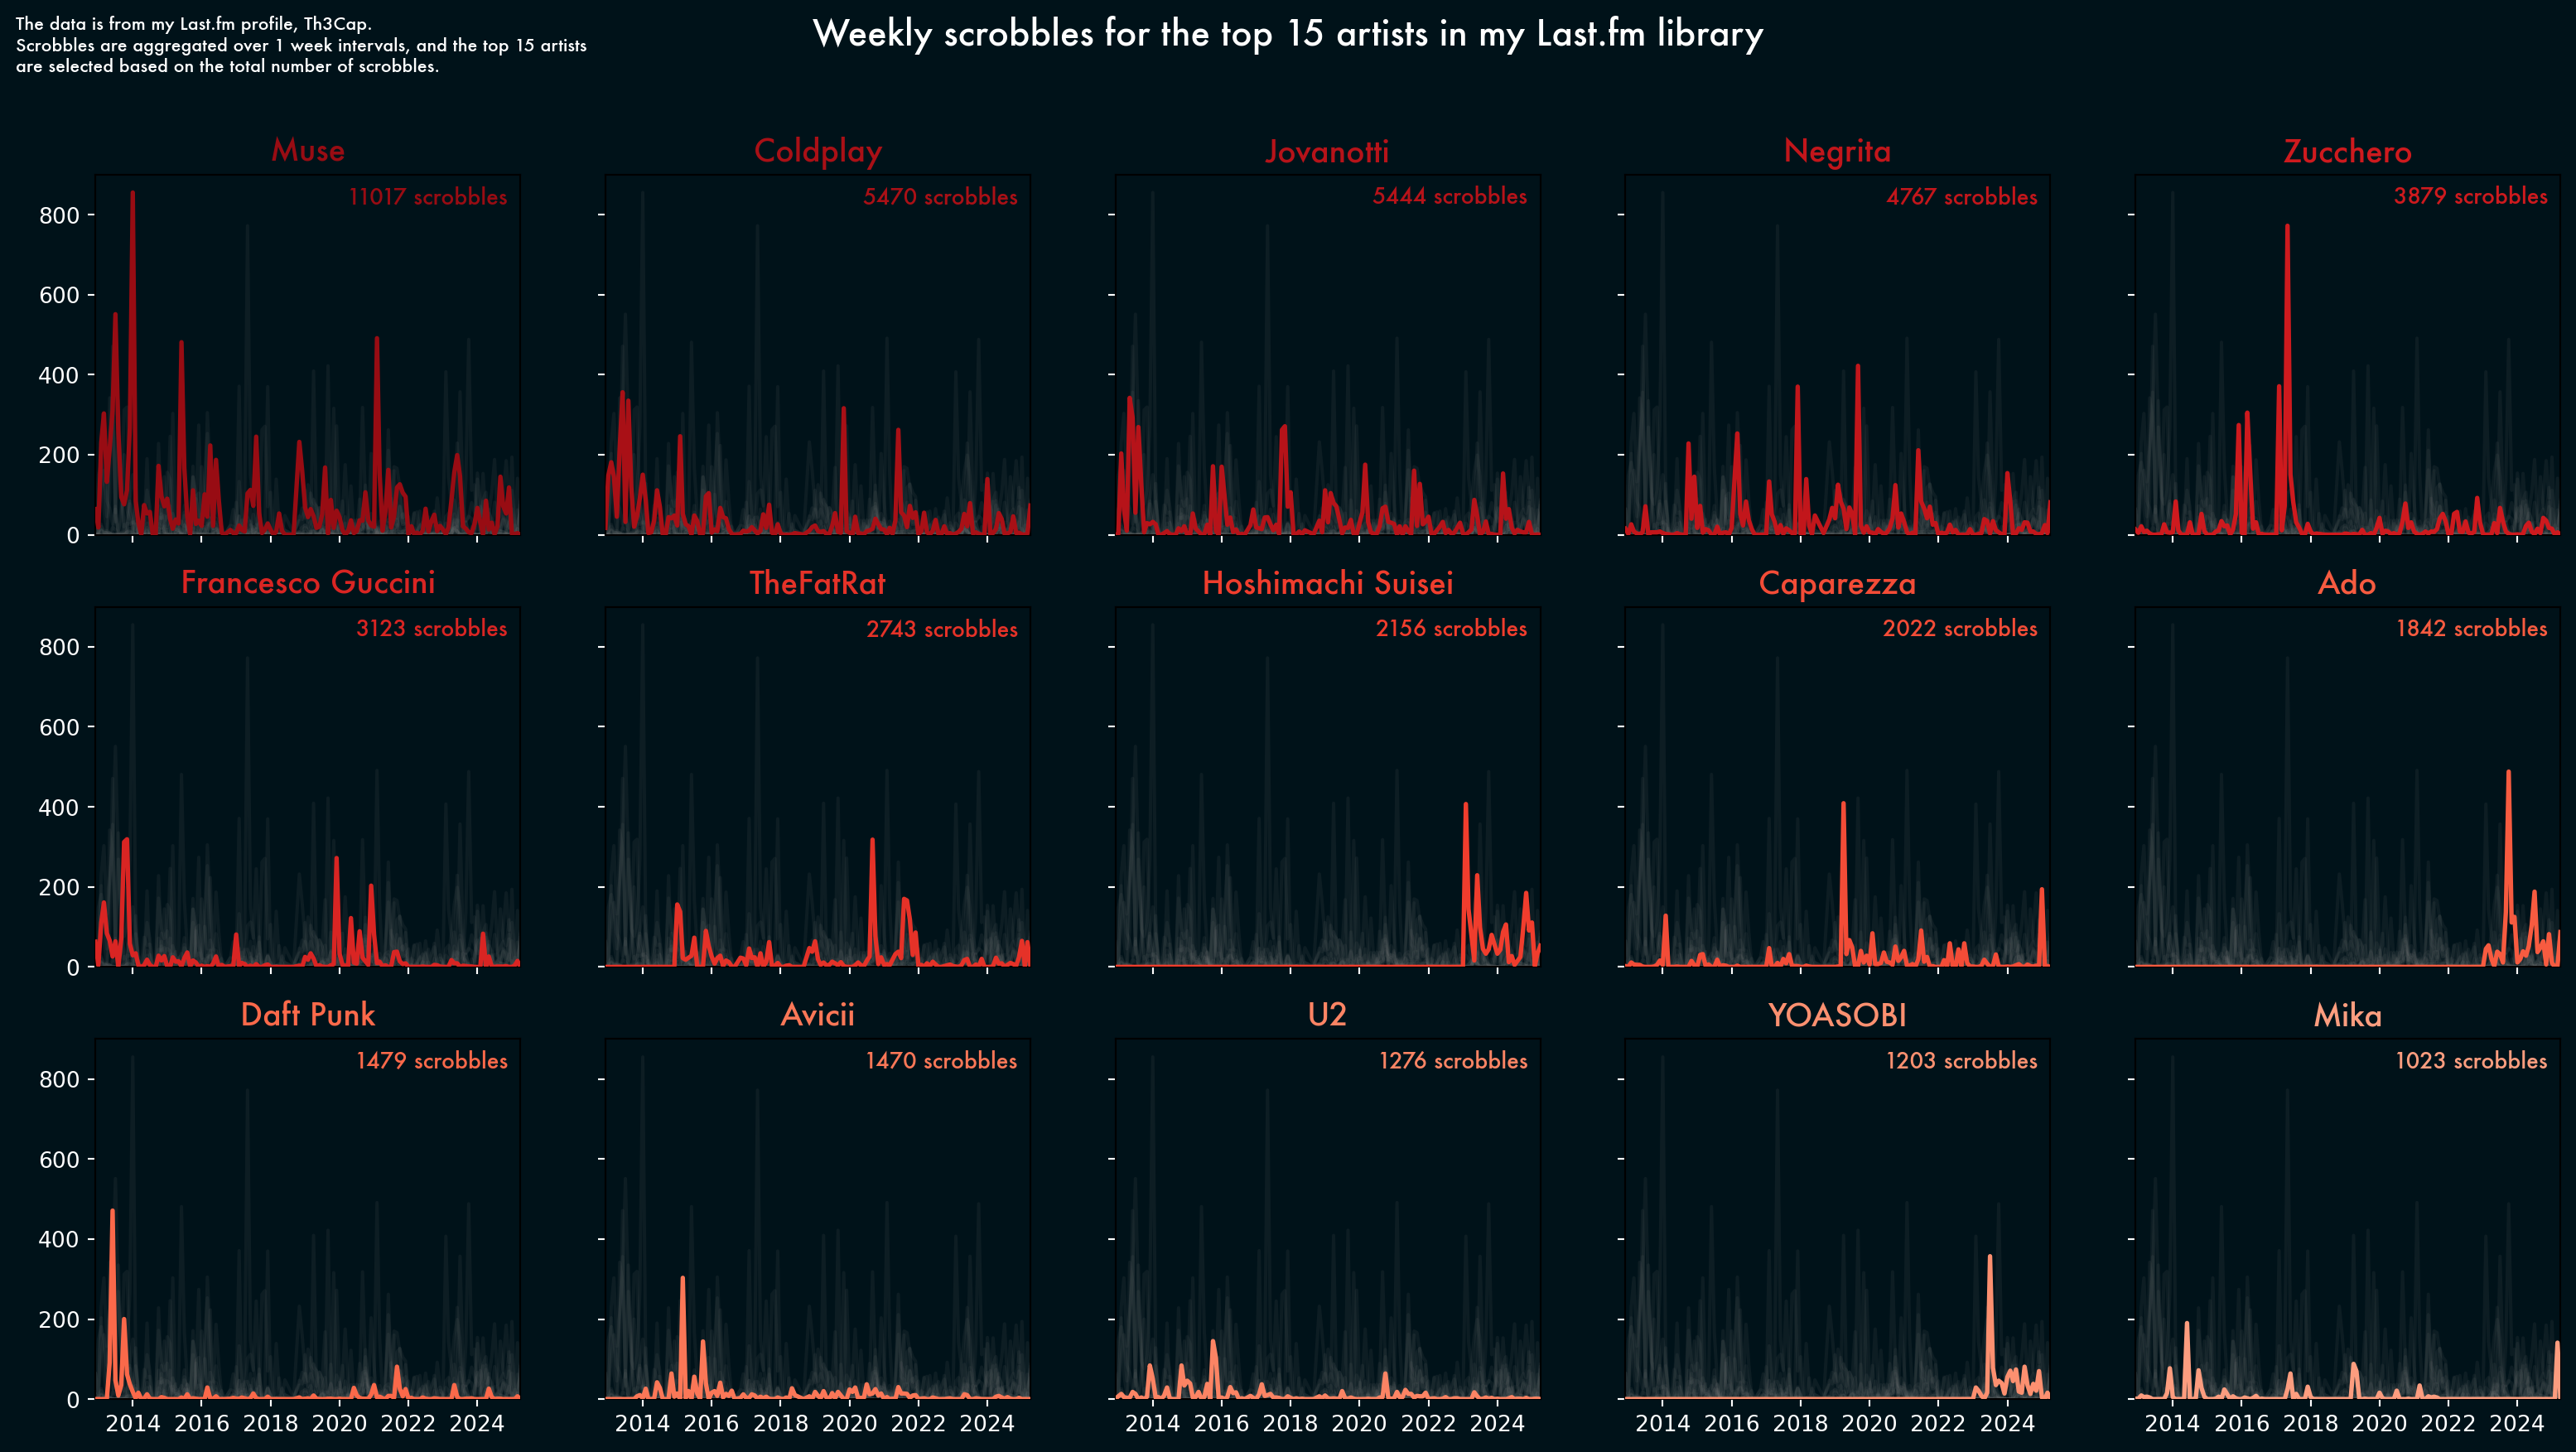

In [13]:
del dict_abs["Everyone else"]
cmap = plt.cm.Reds
colors = cmap(np.linspace(0.3, 0.9, len(order))[::-1])
fig, axs = plt.subplots(3, 5, figsize=(20, 10), sharex=True, sharey=True)
background_color = "#001219"
fig.set_facecolor(background_color)
for i, (k, v) in enumerate(dict_abs.items()):
    color = colors[i]
    if k == "Everyone else":
        continue
    ax = axs[i // 5, i % 5]
    ax.set_facecolor(background_color)
    v = v[mask]
    v = np.nan_to_num(v)
    ax.plot(x, v, color=color, zorder=3, linewidth=2)
    ax.set_title(f"{k}", color=color, fontsize=14, fontweight="bold", fontname="Futura")
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(0, 900)

    ax.tick_params(axis="x", colors="white")
    ax.tick_params(axis="y", colors="white")

    ax.text(
        0.97,
        0.97,
        f"{dict_total[k]} scrobbles",
        ha="right",
        va="top",
        fontsize=10,
        color=color,
        fontname="Futura",
        transform=ax.transAxes,
        )


    for _k, v in dict_abs.items():
        if _k == k:
            continue
        v = v[mask]
        v = np.nan_to_num(v)
        ax.plot(x, v, color="grey", alpha=0.1)

fig.suptitle(
    "Weekly scrobbles for the top 15 artists in my Last.fm library",
    fontsize=16,
    color="white",
    fontname="Futura",
)

desc = """The data is from my Last.fm profile, Th3Cap. 
Scrobbles are aggregated over 1 week intervals, and the top 15 artists 
are selected based on the total number of scrobbles."""

fig.text(
    0.1,
    0.98,
    desc,
    ha="left",
    va="top",
    fontsize=8,
    color="white",
    fontname="Futura",
)

fig.savefig("top_artists_scrobbles.png", dpi=300, bbox_inches="tight")